# Gráficos artículo

***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 21-09-2023*<br>

**Introducción:**<br>
Se generan algunos de los gráficos del documento final.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from tqdm.notebook import tqdm
import yaml
from pathlib import Path
import pickle

from metricas_rendimiento import KGE, KGEmod, ECDF
from plot import rendimiento_LSTM

In [2]:
# # mapa de color para los mapas
# cmap, norm = crear_cmap('RdBu', [-10, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1], name='KGE')

In [3]:
# Set the default text font size
plt.rc('font', size=13)
# Set the axes title font size
plt.rc('axes', titlesize=14)
# Set the axes labels font size
plt.rc('axes', labelsize=13)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=12)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=12)
# Set the legend font size
plt.rc('legend', fontsize=12)
# Set the font size of the figure title
plt.rc('figure', titlesize=15)

plt.rcParams['font.family'] = 'Palatino Linotype'

## Configuración

In [4]:
with open("../config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_anuario = Path(cfg['rutas']['anuario_aforos']['repo'])
path_EFAS = Path(cfg['rutas']['EFAS']['repo'])
path_camels = Path(cfg['rutas']['CAMELS']['repo'])

# inicio y fin del periodo de estudio
cfg_camels = cfg['CAMELS-ES']
start = cfg_camels['periodo'].get('inicio', None)
end = cfg_camels['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

# sistema de referencia de coordenadas de todos los datos
crs = cfg.get('crs', 4326)
proj = ccrs.PlateCarree()

## Datos
### Capas GIS

#### Demarcaciones hidrográficas

In [5]:
demarcaciones = gpd.read_file('../../data/cartografia/hidrografia/demarcaciones.shp')
mask = demarcaciones.NOM_DEMAR.isin(['CANTABRICO ORIENTAL', 'CANTABRICO OCCIDENTAL', 'DUERO', 'EBRO', 'GALICIA-COSTA',
                                     'GUADALQUIVIR', 'GUADIANA', 'JUCAR', 'MIÑO-SIL', 'SEGURA', 'TAJO'])
demarcaciones = demarcaciones[mask]

#### Estaciones 

In [6]:
# # cargar tabla de atributos de Caravan
# atributos = pd.read_csv(path_camels / 'attributes/attributes_caravan_es.csv', index_col=0)
# atributos.index = atributos.index.astype(str)
# # atributos.index = [id.split('_')[-1] for id in atributos.index]



In [7]:
# cargar estaciones
estaciones = gpd.read_file(path_anuario / 'GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)

mask_stn = estaciones.sel == 1

print('nº de estaciones totales:\t{0}'.format(estaciones.shape[0]))
print('nº de estaciones seleccionadas:\t{0}'.format(mask_stn.sum()))

nº de estaciones totales:	1074
nº de estaciones seleccionadas:	269


#### Subcuencas

In [8]:
# cargar polígonos de las cuencas de Caravan
cuencas = gpd.read_file(path_camels / 'shapefiles/catchments_camelses.shp')
cuencas.set_index('gauge_id', drop=True, inplace=True)

n_cuencas = cuencas.shape[0]
print('nº de cuencas en la capa de polígonos:\t{0}'.format(n_cuencas))

nº de cuencas en la capa de polígonos:	269


### Caudal
### Observado: Anuario de Aforos

In [9]:
Qobs = pd.read_parquet(path_anuario / 'caudal.parquet')
Qobs = Qobs[cuencas.index]

Qobs.shape

(10593, 269)

#### Simudo: EFASv5

In [10]:
Qsim = xr.open_dataset(path_EFAS / 'caudal/estaciones/dis_1990_2023.nc')['discharge'].to_pandas()
Qsim = Qsim.loc[start:end,:]

Qsim.shape

(10593, 269)

## Gráficos

### Selección de estaciones

In [11]:
# remapeo del nombre de las cuencas
map_cuencas = {'EBRO': 'Ebro',
                        'DUERO': 'Duero',
                        'TAJO': 'Tajo',
                        'CANTABRICO': 'Cantábrico',
                        'MINHO': 'Miño',
                        'GALICIA': 'Galicia',
                        'JUCAR': 'Júcar',
                        'GUADALQUIVIR': 'Guadalquivir',
                        'GUADIANA': 'Guadiana',
                        'SEGURA': 'Segura'}

# conteo de estaciones seleccionadas por cuenca
count_sel = estaciones[mask_stn].cuenca.value_counts()
count_sel['SEGURA'] = 0
count_sel.rename(index=map_cuencas, inplace=True)

# conteo de estaciones descartadas por cuenca
count_dis = estaciones.cuenca.value_counts()
n_cuencas = count_dis.shape[0]
count_dis.rename(index=map_cuencas, inplace=True)
count_dis = count_dis.loc[count_sel.index]

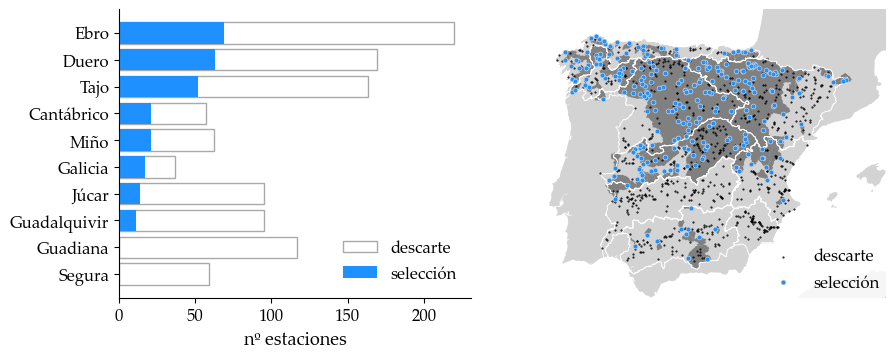

In [12]:
# configuración de la figura
fig = plt.figure(figsize=(10, 3.75))
gs = gridspec.GridSpec(1, 2)

# gráfico de barras del nº de estaciones por cuenca
ax1 = plt.subplot(gs[0])
y_pos = np.arange(n_cuencas)[::-1]
ax1.barh(y_pos, count_dis, facecolor='none', edgecolor='darkgray', align='center', label='descarte')
ax1.barh(y_pos, count_sel, color='dodgerblue', align='center', label='selección')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(count_sel.index.tolist())
ax1.spines[['top', 'right']].set_visible(False)
ax1.set_xlabel('nº estaciones')
ax1.legend(frameon=False, loc=4);

# mapa con las estaciones del Anuario de Aforos seleccionadas/descartadas
ax2 = plt.subplot(gs[1], projection=proj)
ax2.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
ax2.add_feature(cf.NaturalEarthFeature('physical', 'land', '10m', edgecolor=None, facecolor='lightgray'),
               zorder=0)
demarcaciones.plot(ax=ax2, facecolor='none', edgecolor='w', linewidth=0.6, zorder=2)
cuencas.plot(ax=ax2, facecolor='gray', edgecolor='none', zorder=1)
ax2.scatter(estaciones[~mask_stn].geometry.x, estaciones[~mask_stn].geometry.y,
           c='k', marker='.', s=1, label='descarte', zorder=3)
ax2.scatter(estaciones[mask_stn].geometry.x, estaciones[mask_stn].geometry.y,
           c='dodgerblue', s=12, edgecolor='lightgray', lw=.5, label='selección', zorder=4)
ax2.axis('off')
ax2.legend(loc=4, facecolor='w', edgecolor='none', bbox_to_anchor=[.725, -0.03, .3, .1]);

# guardar figura
plt.savefig('../../docs/fig1_seleccion_estaciones.jpg', dpi=300, bbox_inches='tight');

### Rendimiento 

#### EFASv5

In [13]:
# calcular rendimiento
experimento = 'LISFLOOD'
cuencas['KGE'] = np.nan
for id in tqdm(cuencas.index):
    cuencas.loc[id, 'KGE'] = KGE(Qobs[id], Qsim[id])[0]
cuencas.sort_values('area_skm',ascending=False, inplace=True)

  0%|          | 0/269 [00:00<?, ?it/s]

In [16]:
# calcular función de densidad empírica
ecdf = {'EFAS': ECDF(cuencas.KGE, plot=False)}

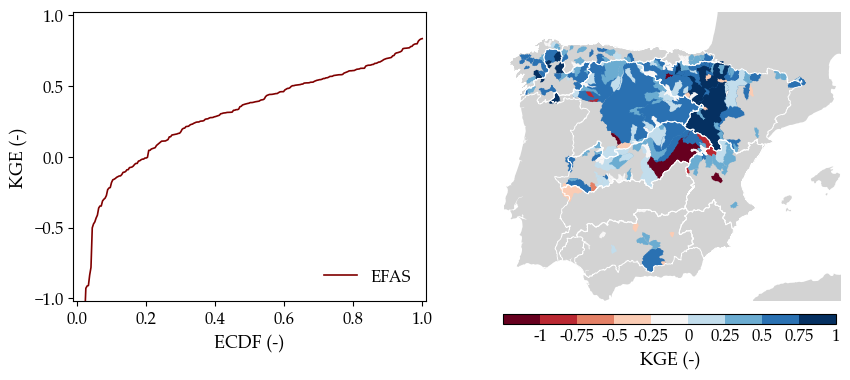

In [18]:
rendimiento_LSTM(cuencas, ecdf, 'KGE', 'EFAS', demarcaciones,
                 '../../docs/fig3_rendimiento_LISFLOOD.jpg')